# Vehicle loan default predection

Importing necessary libs and custom functions

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import Image
from sklearn.ensemble import ExtraTreesClassifier

#importing custom functions from functions.py file
from functions import dateconvert
from functions import yrscalc
from functions import time_diff_months
from functions import resample

In [69]:
df = pd.read_csv(r'../Data/train.csv')

In [70]:
df = df.head(10000)


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   UniqueID                             10000 non-null  int64  
 1   disbursed_amount                     10000 non-null  int64  
 2   asset_cost                           10000 non-null  int64  
 3   ltv                                  10000 non-null  float64
 4   branch_id                            10000 non-null  int64  
 5   supplier_id                          10000 non-null  int64  
 6   manufacturer_id                      10000 non-null  int64  
 7   Current_pincode_ID                   10000 non-null  int64  
 8   Date.of.Birth                        10000 non-null  object 
 9   Employment.Type                      9505 non-null   object 
 10  DisbursalDate                        10000 non-null  object 
 11  State_ID                     

In [71]:
#We can see some columns has wrong data types like date and have missing values in Employment type
df['Date.of.Birth'] = df['Date.of.Birth'].apply(dateconvert,delim='-')
df['DisbursalDate'] = df['DisbursalDate'].apply(dateconvert,delim='-')
df['Employment.Type'].fillna('Unknown',inplace=True)
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01 00:00:00+00:00,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31 00:00:00+00:00,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,1985-08-24 00:00:00+00:00,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,1993-12-30 00:00:00+00:00,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,1977-12-09 00:00:00+00:00,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [72]:
#for purpose of labeling in human format
df['labels'] = df['loan_default'].apply(lambda x:'Paid' if x==0 else "default")

In [73]:
#Feature engineering
#We have features some of which might not be useful or have negligible effect on models.
#we also replace string values with integers.
#Date of birth and loan disbursal dates are used to calculate age of person and time since disbursement of loan
emp_type = {'Unknown':0,'Self employed':1,'Salaried':2}

cns_desc = {'No Bureau History Available':0,
            'Not Scored: Sufficient History Not Available':0,
            'Not Scored: Not Enough Info available on the customer':0,
           'Not Scored: No Activity seen on the customer (Inactive)':0,
           'Not Scored: No Updates available in last 36 months':0,
           'Not Scored: Only a Guarantor':1,
           'Not Scored: More than 50 active Accounts found':1,
           'M-Very High Risk':2,
           'L-Very High Risk':3,
           'K-High Risk':4,
            'J-High Risk':5,
            'H-Medium Risk':6,
            'I-Medium Risk':7,
            'F-Low Risk':8,
            'E-Low Risk':9,
            'G-Low Risk':10,
            'C-Very Low Risk':11,
            'A-Very Low Risk':12,
            'D-Very Low Risk':13,
            'B-Very Low Risk':14
           }
df['Age'] = df['Date.of.Birth'].apply(time_diff_months)
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(yrscalc)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(yrscalc)
df['Age.of.Loan'] = df['DisbursalDate'].apply(time_diff_months)
#combaining to sum of ids
df['No.of.Proofs'] = df[['Aadhar_flag','VoterID_flag','PAN_flag','Driving_flag','Passport_flag','MobileNo_Avl_Flag']].sum(axis=1)

In [74]:
df['PERFORM_CNS.SCORE.DESCRIPTION'] = df['PERFORM_CNS.SCORE.DESCRIPTION'].map(cns_desc).astype('category')
df['Employment.Type'] = df['Employment.Type'].map(emp_type).astype('category')


In [49]:
#Now we can see columns in desired datatypes and 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                               Non-Null Count  Dtype                          
---  ------                               --------------  -----                          
 0   UniqueID                             10000 non-null  int64                          
 1   disbursed_amount                     10000 non-null  int64                          
 2   asset_cost                           10000 non-null  int64                          
 3   ltv                                  10000 non-null  float64                        
 4   branch_id                            10000 non-null  int64                          
 5   supplier_id                          10000 non-null  int64                          
 6   manufacturer_id                      10000 non-null  int64                          
 7   Current_pincode_ID                   10000 non-null  int64                   

In [14]:
#imbalanced data
fig = px.pie(df, names='labels')
fig.show()

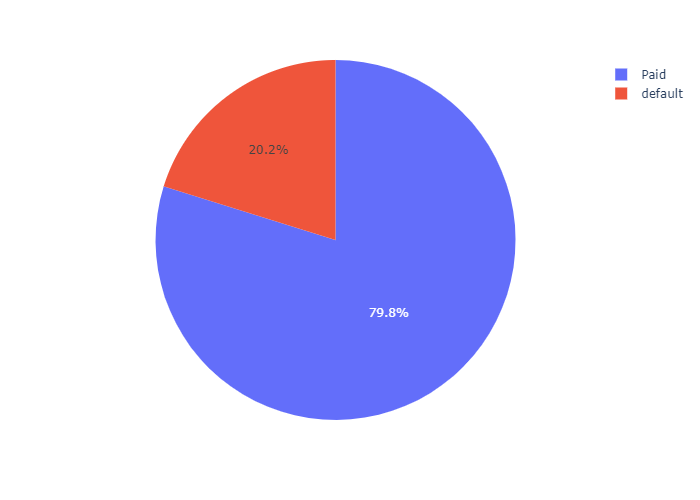

In [15]:
#Static plot for no dynamic render.
fig.write_image(r"../Images/imbalanced_data.png")
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [18]:
#dealing with imbalanced data
os_X,os_y = resample(X,y,'minority')

In [35]:
#feature importance. We drop rudumentry features.
X = df.drop(columns=['UniqueID','loan_default','labels','Date.of.Birth','DisbursalDate','Aadhar_flag','PAN_flag','VoterID_flag','Driving_flag','Passport_flag','MobileNo_Avl_Flag'])
y = df[['loan_default']]

In [36]:
#dealing with imbalanced data
os_X,os_y = resample(X,y,'minority')
etc_model = ExtraTreesClassifier(oob_score=True,random_state=27,bootstrap=True,n_estimators=15)
etc_model.fit(os_X,os_y)

C:\Users\kavin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\kavin\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

C:\Users\kavin\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning:

invalid value encountered in true_divide



ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
                     oob_score=True, random_state=27, verbose=0,
                     warm_start=False)

In [54]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=rf_model,verbose=5)
rfe_selector.fit(os_X, os_y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

C:\Users\kavin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
17 selected features


In [55]:
rfe_feature

['disbursed_amount',
 'asset_cost',
 'ltv',
 'branch_id',
 'supplier_id',
 'manufacturer_id',
 'Current_pincode_ID',
 'Employment.Type',
 'State_ID',
 'Employee_code_ID',
 'PERFORM_CNS.SCORE',
 'PERFORM_CNS.SCORE.DESCRIPTION',
 'PRI.CURRENT.BALANCE',
 'PRIMARY.INSTAL.AMT',
 'CREDIT.HISTORY.LENGTH',
 'Age',
 'Age.of.Loan']

In [42]:
#Craeting a dataframe for a tubular column and sorting them in decending order.
#We can see that features with secondary accounts have negligible. So we combine both primary and secondary account features.
columns = list(X.columns)
pd_feature = pd.DataFrame(data=[columns,etc_model.feature_importances_])
pd_feature = pd_feature.T
pd_feature.columns=['features','scores']
pd_feature.sort_values(['scores'],ascending=False)

,features,scores
32,Age.of.Loan,0.0811093
2,ltv,0.0732353
6,Current_pincode_ID,0.0686393
0,disbursed_amount,0.0671069
31,Age,0.0628559
1,asset_cost,0.0623841
9,Employee_code_ID,0.0592068
5,manufacturer_id,0.0588791
3,branch_id,0.0549201
4,supplier_id,0.0547635


0.8109496366825357

In [ ]:
plt.figure(figsize=(25,25))
fig = px.bar(pd_feature,x='features',y='scores',text='scores', width=900, height=700)
fig.show()

In [ ]:
#non dynamic render.For purpose of being displayed in Github
#Image(filename=r'../Images/feature_score.png')
fig.write_image(r"../Images/feature_score.png")
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [ ]:
etc_model.oob_score_

In [76]:
#we could see that the secondary account features dont contribute much. We will combanie them with the primary account features.
df['Total.ACCTS'] = df[['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS']].sum(axis=1)
df['Total.Active.ACCTS'] = df[['PRI.ACTIVE.ACCTS','SEC.ACTIVE.ACCTS']].sum(axis=1)
df['Total.Overdue.ACCTS'] = df[['PRI.OVERDUE.ACCTS','SEC.OVERDUE.ACCTS']].sum(axis=1)
df['Total.CurrentBalance'] = df[['PRI.CURRENT.BALANCE','SEC.CURRENT.BALANCE']].sum(axis=1)
df['Total.SanctionedAmount'] = df[['PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT']].sum(axis=1)
df['Total.DisbursedAmount'] = df[['PRI.DISBURSED.AMOUNT','SEC.DISBURSED.AMOUNT']].sum(axis=1)
df['Total.InstalAmount'] = df[['PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT']].sum(axis=1)

In [77]:
X = df.drop(columns=['UniqueID','loan_default','labels','Date.of.Birth','DisbursalDate','Aadhar_flag','PAN_flag','VoterID_flag','Driving_flag','Passport_flag','MobileNo_Avl_Flag','PRI.NO.OF.ACCTS',
                    'SEC.NO.OF.ACCTS','PRI.ACTIVE.ACCTS','SEC.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS','SEC.OVERDUE.ACCTS','PRI.CURRENT.BALANCE','SEC.CURRENT.BALANCE',
                    'PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT','SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT'])
y = df[['loan_default']]

In [87]:
X[X.isna()]

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,Employee_code_ID,...,Age,Age.of.Loan,No.of.Proofs,Total.ACCTS,Total.Active.ACCTS,Total.Overdue.ACCTS,Total.CurrentBalance,Total.SanctionedAmount,Total.DisbursedAmount,Total.InstalAmount
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
os_X,os_y = resample(X,y,'minority')
rfe_selector = RFE(estimator=rf_model,verbose=5)
rfe_selector.fit(os_X, os_y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [38]:
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
brc_model = BalancedRandomForestClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=27)
scores = cross_val_score(brc_model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print(f'Mean AUC_ROC score : {scores.mean()}')

Mean AUC_ROC score : 0.6077891751967665


In [39]:
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
brc_model = BalancedRandomForestClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=27)
scores = cross_val_score(brc_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f'Accuracy : {scores.mean()}')

Accuracy : 0.5801000000000001


In [40]:
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=27)
scores = cross_val_score(rf_model, os_X, os_y, scoring='roc_auc', cv=cv, n_jobs=-1)
print(f'Mean AUC_ROC score : {scores.mean()}')

Mean AUC_ROC score : 0.9072934703242211


In [41]:
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=27)
scores = cross_val_score(rf_model, os_X, os_y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f'Accuracy : {scores.mean()}')

Accuracy : 0.8468219703924809


In [ ]:
from sklearn.metrics import classification_report
c_report = classification_report(test_targets,y_pred_logmodel,target_names=['Negative','Positive'])